### Урок 6. Сегментация

### -- Автор: Шенк Евгений Станиславович

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть U-Net либо на другом датасете либо с другим бэкбоном (другой свёрточной частью). 
        Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    </li>
</ol>

Выполнение:
    1. Для сравнения были использованы разные бэкбоны (MobileNetV2; ResNet50V2; VGG19).  
    2. Улучшение точности было достигнуто за счет увеличения эпох с 5 до 10 (дальнейшее увеличение результат существенно не улучшало) 
    3. Наилучший вариант оказался MobileNetV2 - точнее и быстрее других.
    4. Для ResNet50V2 и VGG19 перебор различных слоев (с помощью base_model.summary() и образцов из интернета) результат изменял, но все равно оказался хуже варианта с MobileNetV2 (из методички). Возможно, подобранные варианты слоев далеки от оптимального.  
    5. Изменение оптимизатора только ухудшало результат. Оптимизатор оставлен «Adam».  

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

### Аугментация

In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [4]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [5]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

### Train-Test

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [8]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

### Models

##### MobileNetV2

In [9]:
OUTPUT_CHANNELS = 3

In [10]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# base_model.summary()

In [11]:
# base_model.summary()

In [12]:
def MobileNetV2_layers():
    base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False
    
    return down_stack

#### ResNet50V2

In [13]:
# base_model = tf.keras.applications.ResNet50V2(input_shape=[128, 128, 3], include_top=False)
# base_model.summary()

In [14]:
def ResNet50V2_layers():
    base_model = tf.keras.applications.ResNet50V2(input_shape=[128, 128, 3], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'conv1_conv',            # 64x64
        'conv2_block2_2_relu',   # 32x32
        'conv3_block2_2_relu',   # 16x16
        'conv4_block2_2_relu',   # 8x8
        'conv5_block2_2_relu',   # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False
    
    return down_stack

#### VGG19

In [15]:
# base_model = tf.keras.applications.VGG19(input_shape=(128, 128, 3), include_top=False)
# base_model.summary()

In [16]:
def VGG19_layers():
    base_model = tf.keras.applications.VGG19(input_shape=(128, 128, 3), include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block1_pool',   # 64x64
        'block2_pool',   # 32x32
        'block3_pool',   # 16x16
        'block4_pool',   # 8x8
        'block5_pool',   # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False
    
    return down_stack

## UNET

In [17]:
def unet_model(output_channels, down_stack):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Train Model

In [18]:
# MobileNetV2 ; ResNet50V2 ; VGG19

In [19]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

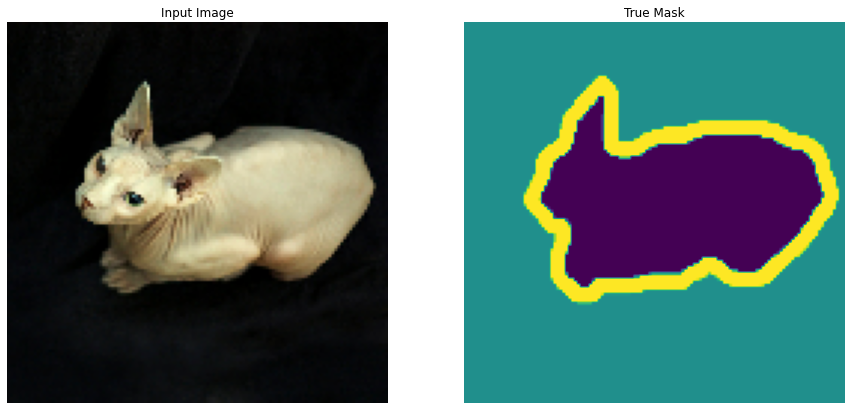

In [22]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [24]:
EPOCHS = 10 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [25]:
def model_fit(model):
    with tf.device('/gpu:0'):
        model_history = model.fit(train_dataset, epochs=EPOCHS,
                                  steps_per_epoch=STEPS_PER_EPOCH,
                                  validation_steps=VALIDATION_STEPS,
                                  validation_data=test_dataset,
                                  callbacks=[DisplayCallback()])
        return model_history

#### Fit: MobileNetV2

In [26]:
model_MobileNetV2 = unet_model(output_channels=OUTPUT_CHANNELS, down_stack=MobileNetV2_layers())
model_MobileNetV2.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

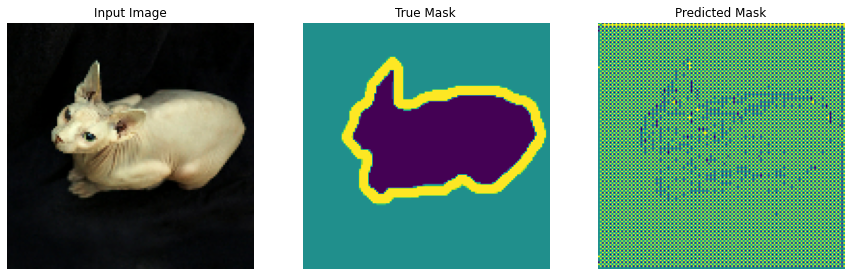

In [27]:
model = model_MobileNetV2
show_predictions()

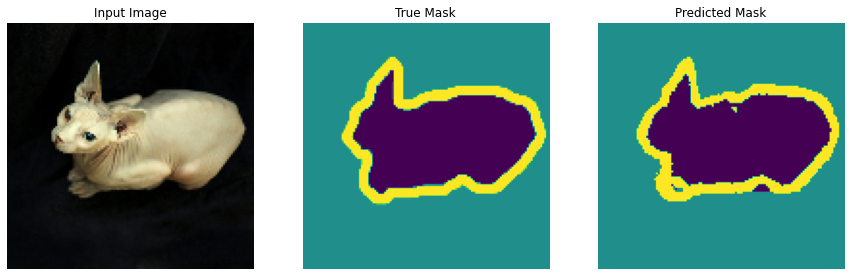


Sample Prediction after epoch 10

57/57 [==============================] - 10s 184ms/step - loss: 0.2076 - accuracy: 0.9100 - val_loss: 0.2697 - val_accuracy: 0.8930


In [28]:
model_history = model_fit(model=model_MobileNetV2)

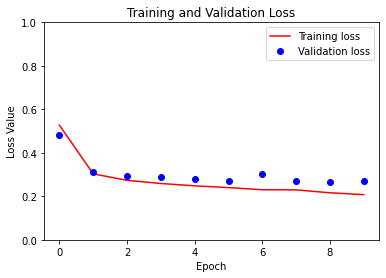

In [29]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

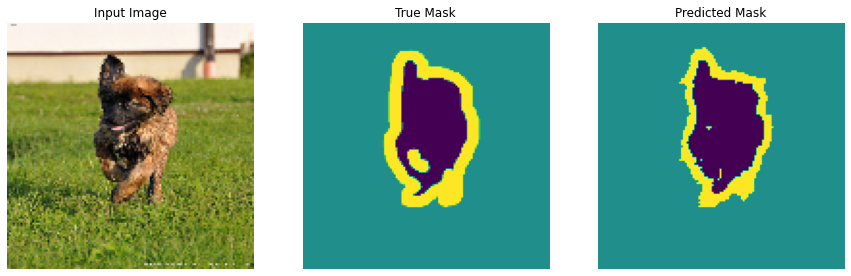

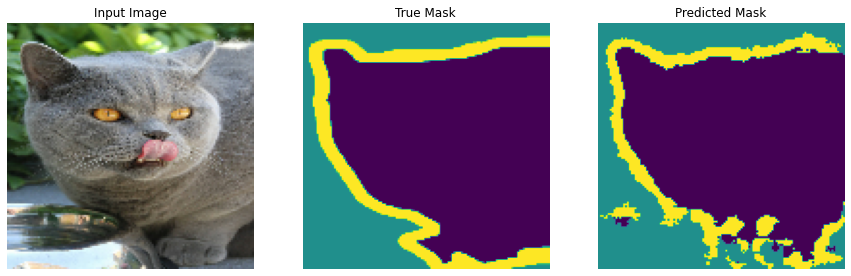

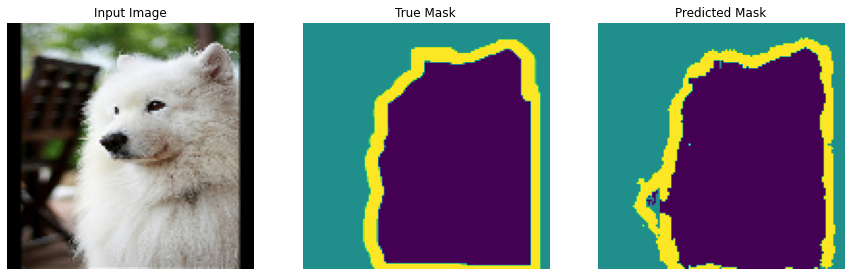

In [30]:
show_predictions(test_dataset, 3)

#### Fit: ResNet50V2

In [31]:
model_ResNet50V2 = unet_model(output_channels=OUTPUT_CHANNELS, down_stack=ResNet50V2_layers())
model_ResNet50V2.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

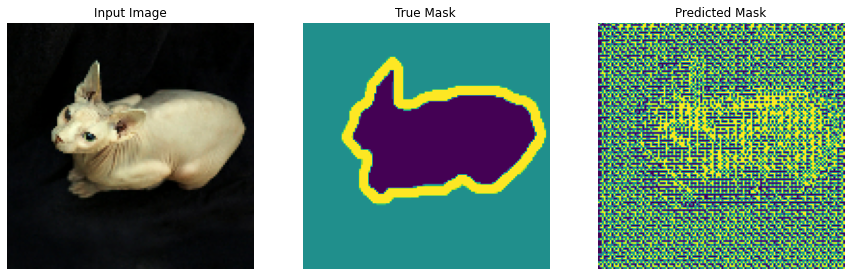

In [32]:
model = model_ResNet50V2
show_predictions()

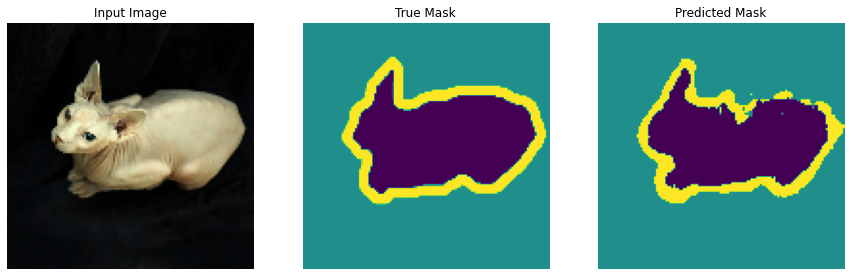


Sample Prediction after epoch 10

57/57 [==============================] - 12s 209ms/step - loss: 0.1680 - accuracy: 0.9249 - val_loss: 0.4208 - val_accuracy: 0.8559


In [33]:
model_fit(model_ResNet50V2)

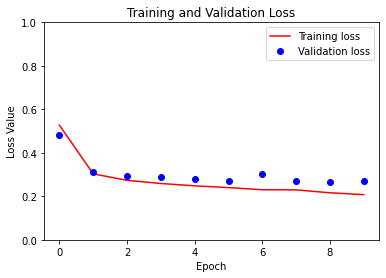

In [34]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

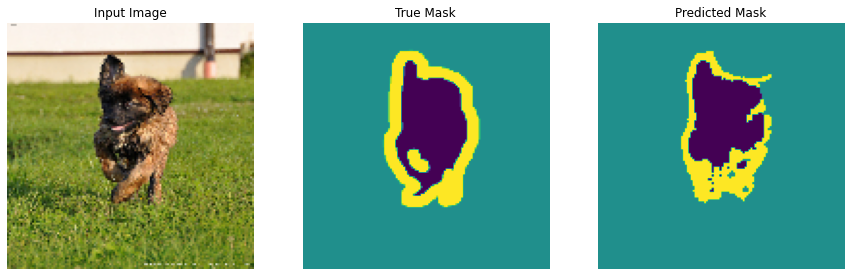

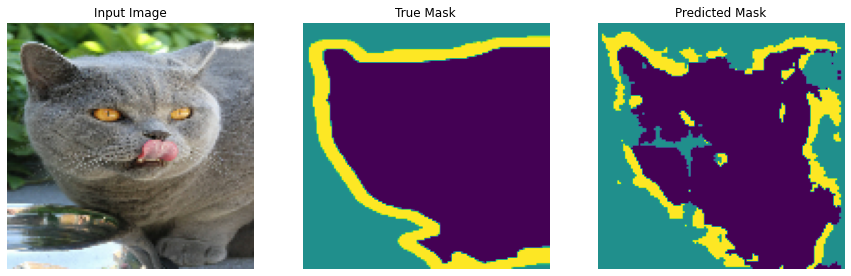

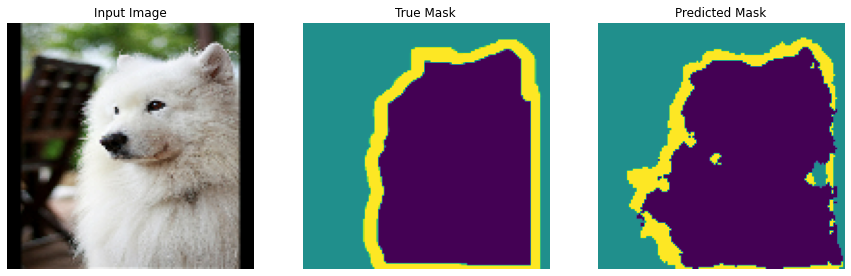

In [35]:
show_predictions(test_dataset, 3)

#### Fit: VGG19

In [36]:
model_VGG19 = unet_model(output_channels=OUTPUT_CHANNELS, down_stack=VGG19_layers())
model_VGG19.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

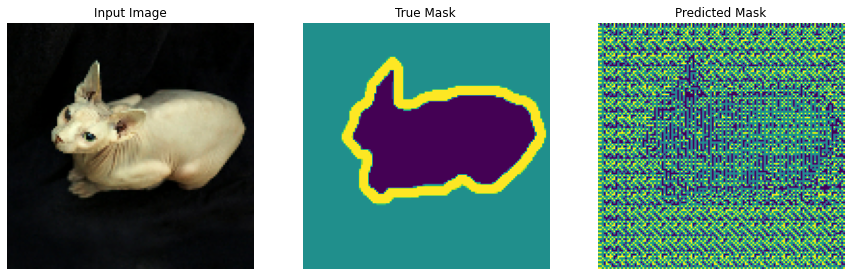

In [37]:
model = model_VGG19
show_predictions()

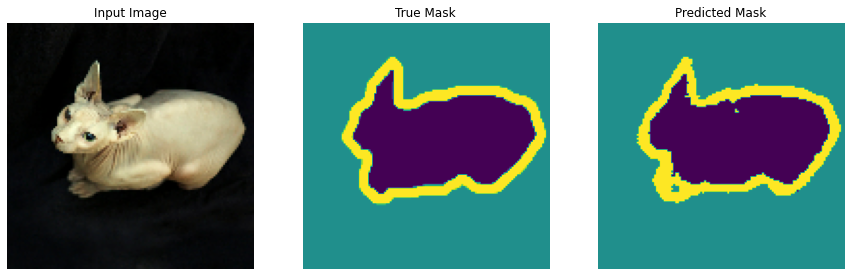


Sample Prediction after epoch 10

57/57 [==============================] - 15s 272ms/step - loss: 0.2403 - accuracy: 0.8974 - val_loss: 0.3420 - val_accuracy: 0.8676


In [38]:
model_fit(model_VGG19)

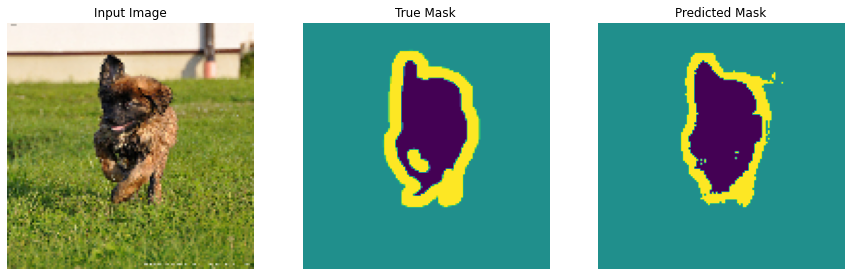

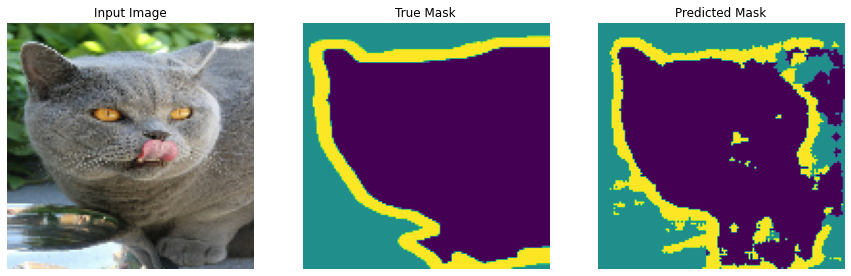

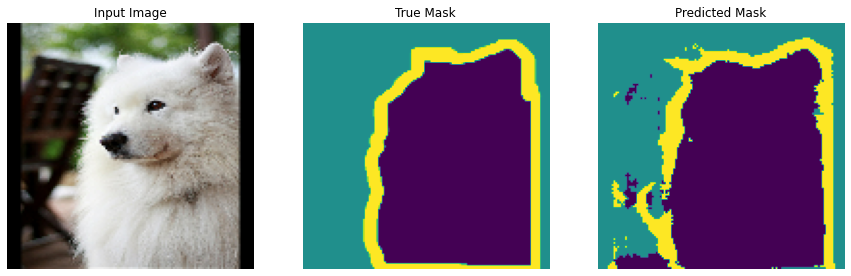

In [39]:
show_predictions(test_dataset, 3)

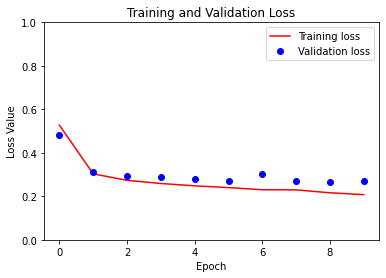

In [40]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()